<a href="https://colab.research.google.com/github/jain-harshil/Neural-Catchphrase-Generation/blob/master/abstractive_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References
https://github.com/aravindpai/How-to-build-own-text-summarizer-using-deep-learning/blob/master/How_to_build_own_text_summarizer_using_deep_learning.ipynb

Setting path for my files(dataset and activation.py)

In [0]:
import sys
sys.path.insert(1, '/content/drive/My Drive/NLP/')

In [179]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Custom Attention Layer

attention.py is another python file.
For prediction of words, the whole text is usually unecessary. AttentionLayer is used to extract those specific words from the text.
Example: Which sport do you like?
Ans: I love football.
Here, I can be derived from you; love from like; and football from sport.

In [102]:
!pip install keras-self-attention

In [0]:
from attention import AttentionLayer
from keras_self_attention import SeqSelfAttention

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import re
import random
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [105]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading and Preprocessing Data


In [106]:
data = pd.read_csv("/content/drive/My Drive/NLP/extracted_documents3.csv")
data.head()

,Abstract,Title,extracted_text
0,We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joi...,Dual Recurrent Attention Units for Visual Question Answering,The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts ...
1,"Recent approaches based on artificial neural networks (ANNs) have shown\npromising results for short-text classification. However, many short texts\noccur in sequences (e.g., sentences in a docume...",Sequential Short-Text Classification with Recurrent and Convolutional\n Neural Networks,"Recent approaches based on artificial neural networks (ANNs) have shown\npromising results for short-text classification. However, many short texts\noccur in sequences (e.g., sentences in a docume..."
2,"We introduce the multiresolution recurrent neural network, which extends the\nsequence-to-sequence framework to model natural language generation as two\nparallel discrete stochastic processes: a ...",Multiresolution Recurrent Neural Networks: An Application to Dialogue\n Response Generation,"natural language tokens (word\nperplexity), optimizing the joint log-likelihood biases the model towards\nmodeling high-level abstractions. Finally, our experiments\ndemonstrate that the proposed ..."
3,"Multi-task learning is motivated by the observation that humans bring to bear\nwhat they know about related problems when solving new ones. Similarly, deep\nneural networks can profit from related...",Learning what to share between loosely related tasks,"In Natural Language Processing (NLP), it is hard to predict if\nsharing will lead to improvements, particularly if tasks are only loosely\nrelated. We perform\nexperiments on three task pairs, and..."
4,We present MILABOT: a deep reinforcement learning chatbot developed by the\nMontreal Institute for Learning Algorithms (MILA) for the Amazon Alexa Prize\ncompetition. MILABOT is capable of convers...,A Deep Reinforcement Learning Chatbot,"By applying reinforcement learning to\ncrowdsourced data and real-world user interactions, the system has been trained\nto select an appropriate response from the models in its ensemble. The syste..."


In [107]:
data = data.dropna()
data.reset_index(drop=True,inplace=True)
data.shape

(61399, 3)

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [0]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['extracted_text']:
    cleaned_text.append(text_cleaner(t))

In [0]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    # tokens = [w for w in newString.split() if not w in stop_words]
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Title']:
    cleaned_summary.append(summary_cleaner(t))

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [112]:
data.head()

,Abstract,Title,extracted_text,cleaned_text,cleaned_summary
0,We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joi...,Dual Recurrent Attention Units for Visual Question Answering,The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts ...,memory characteristic proposed recurrent attention units offers rich joint embedding visual textual features enables model reason relations several parts image question also experiment replacing a...,dual recurrent attention units for visual question answering
1,"Recent approaches based on artificial neural networks (ANNs) have shown\npromising results for short-text classification. However, many short texts\noccur in sequences (e.g., sentences in a docume...",Sequential Short-Text Classification with Recurrent and Convolutional\n Neural Networks,"Recent approaches based on artificial neural networks (ANNs) have shown\npromising results for short-text classification. However, many short texts\noccur in sequences (e.g., sentences in a docume...",recent approaches based artificial neural networks shown promising results short text classification however many short texts occur sequences existing ann based systems leverage preceding short te...,sequential short text classification with recurrent and convolutional neural networks
2,"We introduce the multiresolution recurrent neural network, which extends the\nsequence-to-sequence framework to model natural language generation as two\nparallel discrete stochastic processes: a ...",Multiresolution Recurrent Neural Networks: An Application to Dialogue\n Response Generation,"natural language tokens (word\nperplexity), optimizing the joint log-likelihood biases the model towards\nmodeling high-level abstractions. Finally, our experiments\ndemonstrate that the proposed ...",natural language tokens optimizing joint log likelihood biases model towards modeling high level abstractions finally experiments demonstrate proposed model adept overcoming sparsity natural langu...,multiresolution recurrent neural networks an application to dialogue response generation
3,"Multi-task learning is motivated by the observation that humans bring to bear\nwhat they know about related problems when solving new ones. Similarly, deep\nneural networks can profit from related...",Learning what to share between loosely related tasks,"In Natural Language Processing (NLP), it is hard to predict if\nsharing will lead to improvements, particularly if tasks are only loosely\nrelated. We perform\nexperiments on three task pairs, and...",natural language processing hard predict sharing lead improvements particularly tasks loosely related perform experiments three task pairs across seven different domains using data ontonotes achie...,learning what to share between loosely related tasks
4,We present MILABOT: a deep reinforcement learning chatbot developed by the\nMontreal Institute for Learning Algorithms (MILA) for the Amazon Alexa Prize\ncompetition. MILABOT is capable of convers...,A Deep Reinforcement Learning Chatbot,"By applying reinforcement learning to\ncrowdsourced data and real-world user interactions, the system has been trained\nto select an appropriate response from the models in its ensemble. The syste...",applying reinforcement learning crowdsourced data real world user interactions system trained select appropriate response models ensemble system evaluated testing real world users performed signif...,deep reinforcement learning chatbot


In [113]:
len(data)

61399

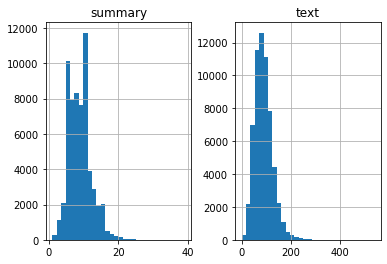

In [114]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))
    
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [116]:
count_len_text = 0
for i in data['cleaned_summary']:
  if(len(i.split())<15):
    count_len_text += 1
    
print(count_len_text/len(data['cleaned_text']))

0.9456994413589798


94% of the dataset has titles which are less than 15 words. 92% of the dataset has extracted abstract with less than 100 words

In [0]:
max_text_len=200
max_summary_len=15

In [0]:
org_text = np.array(data['Abstract'])
org_title = np.array(data['Title'])
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

original_text = []
original_title = []
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        original_text.append(org_text[i])
        original_title.append(org_title[i])
        
        
df=pd.DataFrame({'Abstract':original_text,'Title':original_title,'text':short_text,'summary':short_summary})

sostok - start tag of title <br> estok - end tag of title

In [0]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [120]:
df.head()

,Abstract,Title,text,summary
0,We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joi...,Dual Recurrent Attention Units for Visual Question Answering,memory characteristic proposed recurrent attention units offers rich joint embedding visual textual features enables model reason relations several parts image question also experiment replacing a...,sostok dual recurrent attention units for visual question answering eostok
1,"Recent approaches based on artificial neural networks (ANNs) have shown\npromising results for short-text classification. However, many short texts\noccur in sequences (e.g., sentences in a docume...",Sequential Short-Text Classification with Recurrent and Convolutional\n Neural Networks,recent approaches based artificial neural networks shown promising results short text classification however many short texts occur sequences existing ann based systems leverage preceding short te...,sostok sequential short text classification with recurrent and convolutional neural networks eostok
2,"We introduce the multiresolution recurrent neural network, which extends the\nsequence-to-sequence framework to model natural language generation as two\nparallel discrete stochastic processes: a ...",Multiresolution Recurrent Neural Networks: An Application to Dialogue\n Response Generation,natural language tokens optimizing joint log likelihood biases model towards modeling high level abstractions finally experiments demonstrate proposed model adept overcoming sparsity natural langu...,sostok multiresolution recurrent neural networks an application to dialogue response generation eostok
3,"Multi-task learning is motivated by the observation that humans bring to bear\nwhat they know about related problems when solving new ones. Similarly, deep\nneural networks can profit from related...",Learning what to share between loosely related tasks,natural language processing hard predict sharing lead improvements particularly tasks loosely related perform experiments three task pairs across seven different domains using data ontonotes achie...,sostok learning what to share between loosely related tasks eostok
4,We present MILABOT: a deep reinforcement learning chatbot developed by the\nMontreal Institute for Learning Algorithms (MILA) for the Amazon Alexa Prize\ncompetition. MILABOT is capable of convers...,A Deep Reinforcement Learning Chatbot,applying reinforcement learning crowdsourced data real world user interactions system trained select appropriate response models ensemble system evaluated testing real world users performed signif...,sostok deep reinforcement learning chatbot eostok


Split the data into train and validation set in 90/10 ratio

In [0]:
l = int(len(df)*0.1)
x_val_org_abs = []
x_val_org_title = []
x_val = []
y_val = []
x_tr = []
y_tr = []
val_samples = random.sample(range(len(df)), l)
for i in range(len(df)):
  if(i in val_samples):
    x_val_org_abs.append(df['Abstract'][i])
    x_val_org_title.append(df['Title'][i])
    x_val.append(df['text'][i])
    y_val.append(df['summary'][i])
  else:
    x_tr.append(df['text'][i])
    y_tr.append(df['summary'][i])

x_val = np.array(x_val)
y_val = np.array(y_val)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)

In [0]:
# from sklearn.model_selection import train_test_split
# x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=1,shuffle=True)

In [123]:
len(x_tr), len(y_tr), len(x_val), len(y_val)

(52830, 52830, 5870, 5870)

# Tokenizer
Converting words to integers

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

## Rarewords and its Coverage
Let us look at the proportion rare words and its total coverage in the entire summary
<br>
Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word

In [125]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.458870609159625
Total Coverage of rare words: 1.3320290679721463


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [127]:
x_voc

25330

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [129]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.36615811373093
Total Coverage of rare words: 4.80375884533503


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [131]:
y_voc

5113

In [132]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(52830, 52830)


Here, I am deleting the rows that contain only START and END tokens

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model
This is an encoder decoder model.
<br>
Encoder has 1 embedding layer and 3 lstm layers
decoder has 1 embedding, 1 lstm, 1 attention, 1 concatenation and 1 dense layer

In [135]:
from keras import backend as K 
import tensorflow as tf

K.clear_session()

from tensorflow.keras.layers import Reshape

latent_dim = 500
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)


#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)



# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])


# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     5066000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 500), ( 1402000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Use EarlyStopping to stop when validation loss starts to increase

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [138]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 52804 samples, validate on 5867 samples
Epoch 1/50
52804/52804 [==============================] - 579s 11ms/sample - loss: 3.9093 - acc: 0.4380 - val_loss: 3.5373 - val_acc: 0.4692
Epoch 2/50
52804/52804 [==============================] - 580s 11ms/sample - loss: 3.4495 - acc: 0.4738 - val_loss: 3.2738 - val_acc: 0.4918
Epoch 3/50
52804/52804 [==============================] - 577s 11ms/sample - loss: 3.2178 - acc: 0.4941 - val_loss: 3.1084 - val_acc: 0.5075
Epoch 4/50
52804/52804 [==============================] - 569s 11ms/sample - loss: 3.0531 - acc: 0.5088 - val_loss: 2.9940 - val_acc: 0.5208
Epoch 5/50
52804/52804 [==============================] - 568s 11ms/sample - loss: 2.9307 - acc: 0.5193 - val_loss: 2.9198 - val_acc: 0.5267
Epoch 6/50
52804/52804 [==============================] - 570s 11ms/sample - loss: 2.8309 - acc: 0.5284 - val_loss: 2.8782 - val_acc: 0.5310
Epoch 7/50
52804/52804 [==============================] - 569s 11ms/sample - loss: 2.7476 - acc: 0.5353 -

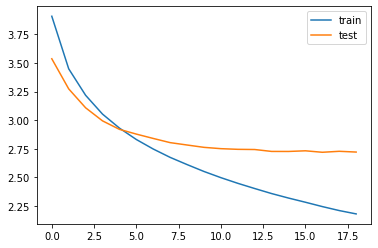

In [139]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

define dictionaries to convert integers to their corrosponding words for text and titles

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference
Setting up inference for the encoder and decoder. It is used for prediction.

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Function for implementing the Inference

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for title as well as the abstract:

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Predict 100 titles from the validation set

In [157]:
for i in range(0,100):
    print("Abstract:",x_val_org_abs[i])
    print("Extracted Text: ", seq2text(x_val[i]))
    print("Original title:",x_val_org_title[i])
    print("Cleaned summary:",seq2summary(y_val[i]))
    print("Predicted title:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Abstract: We introduce the multiresolution recurrent neural network, which extends the
sequence-to-sequence framework to model natural language generation as two
parallel discrete stochastic processes: a sequence of high-level coarse tokens,
and a sequence of natural language tokens. There are many ways to estimate or
learn the high-level coarse tokens, but we argue that a simple extraction
procedure is sufficient to capture a wealth of high-level discourse semantics.
Such procedure allows training the multiresolution recurrent neural network by
maximizing the exact joint log-likelihood over both sequences. In contrast to
the standard log- likelihood objective w.r.t. natural language tokens (word
perplexity), optimizing the joint log-likelihood biases the model towards
modeling high-level abstractions. We apply the proposed model to the task of
dialogue response generation in two challenging domains: the Ubuntu technical
support domain, and Twitter conversations. On Ubuntu, the model o

# BLEU SCORE

In [0]:
from nltk.translate.bleu_score import sentence_bleu

total_score = 0
total_count = 0
total_score1 = 0
total_count1 = 0

for i in range(len(x_val)):
  
  result_title = decode_sequence(x_val[i].reshape(1,max_text_len))
  actual_title = seq2summary(y_val[i])
  
  score = sentence_bleu([actual_title.split(" ")],result_title.split(" "))
  total_score += score
  total_count += 1
  score = sentence_bleu([x_val_org_title[i].split(" ")],result_title.split(" "))
  total_score1 += score
  total_count1 += 1

In [151]:
print("Average BLEU Score on validation set (after removal of stopwords from title): ",total_score/total_count)

Average BLEU Score on validation set (after removal of stopwords from title):  0.49508788806349663


In [152]:
print("Average BLEU Score on validation set (using original titles): ",total_score1/total_count1)

Average BLEU Score on validation set (using original titles):  0.19229979038589734


# Saving Models and Tokenizer

In [0]:
model.save("/content/drive/My Drive/NLP/titlegen.h5")

In [0]:
decoder_model.save("/content/drive/My Drive/NLP/titlegenPredict.h5")

In [0]:
import pickle

with open('/content/drive/My Drive/NLP/ytokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('/content/drive/My Drive/NLP/xtokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)